In [5]:
import sys
import tkinter as tk
from tkinter import filedialog
import os
import pyabf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.stats.power import TTestIndPower
# Ensure the functions directory is included in the system path
sys.path.append(os.path.join(os.getcwd(), '..', 'functions'))
from abf_functions import read_abf_files, extract_cell_info, extract_stages, delete_sweeps, save_data_to_csv, save_data_with_dask, plot_grouped_by_file
import ipywidgets as widgets
from IPython.display import display, HTML

In [ ]:
effect_size = 0.47  # Розмір ефекту
alpha = 0.05  # P-value (рівень значущості)
power = 0.8  # Статистична потужність (зазвичай 80%)
ratio = 1  # Відношення розміру вибірок (1 означає рівні вибірки)

# Ініціалізуємо об'єкт TTestIndPower для Welch's t-test (з використанням unequal_var=True)
analysis = TTestIndPower()

# Розрахунок розміру вибірки для Welch's t-test з різними дисперсіями
sample_size = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=ratio, alternative='two-sided')

print(f'Необхідний розмір вибірки для Welch\'s t-test: {np.ceil(sample_size)}')

# Розрахунок потужності, знаючи розмір вибірки
power_calc = analysis.power(effect_size=effect_size, nobs1=sample_size, alpha=alpha, ratio=ratio, alternative='two-sided')

print(f'Розрахована потужність для Welch\'s t-test: {power_calc}')

In [8]:
def select_directory():
    root = tk.Tk()
    root.withdraw()  # Закрити основне вікно
    main_directory = filedialog.askdirectory(title="Виберіть головну директорію з ABF файлами")
    return main_directory

# Виклик функції для вибору директорії
main_directory = select_directory()

# Якщо директорія була вибрана, викликаємо функцію для зчитування файлів
if main_directory:
    print(f"Вибрана директорія: {main_directory}")
    
    # Виклик функції для зчитування ABF файлів
    data = read_abf_files(main_directory)
    
    # Вивести результуючий DataFrame
    print(data)
else:
    print("Директорію не було вибрано.")

Вибрана директорія: D:/Наука/Проєкти/K-АТФ чутливі канали/Кардіоміоцити/Дорослі/Дані/Adult/Adult_CM_analysis/data
             Folder                 File  Sweep  Time (s)  Data (ADC)  \
0        2023.02.28  2023-02-28_0000.abf      1    0.0000 -159.999985   
1        2023.02.28  2023-02-28_0000.abf      1    0.0002 -164.999985   
2        2023.02.28  2023-02-28_0000.abf      1    0.0004 -159.999985   
3        2023.02.28  2023-02-28_0000.abf      1    0.0006 -164.999985   
4        2023.02.28  2023-02-28_0000.abf      1    0.0008 -159.999985   
...             ...                  ...    ...       ...         ...   
1201243  2024.07.01  2024-07-02_0004.abf     10    0.1027 -259.999969   
1201244  2024.07.01  2024-07-02_0004.abf     10    0.1028 -254.999969   
1201245  2024.07.01  2024-07-02_0004.abf     10    0.1029 -254.999969   
1201246  2024.07.01  2024-07-02_0004.abf     10    0.1030 -254.999969   
1201247  2024.07.01  2024-07-02_0004.abf     10    0.1031 -254.999969   

         

Подивимося унікальні коментарі протоколів для того аби присвоїти етапи(зовнішній розчин, блокатор) записів циклам(sweeps)

In [9]:
# Налаштування параметрів для відображення
pd.set_option('display.max_columns', None)  # Показати всі колонки
pd.set_option('display.width', None)         # Не обмежувати ширину
pd.set_option('display.max_colwidth', None)  # Не обмежувати ширину стовпців

# Отримуємо унікальні значення з колонки "Protocol Comments"
unique_protocol_comments = data[['Protocol Comments']].drop_duplicates()
unique_protocol_files = data[['File']].drop_duplicates()
unique_protocol_epoch = data[['Epoch']].drop_duplicates()

# Виводимо перші кілька записів для перегляду
print("Унікальні записи з колонок:")
display(unique_protocol_comments, unique_protocol_files, unique_protocol_epoch)

Унікальні записи з колонок:


,Protocol Comments
0,"#1 CM 37sw - BK, 89sw - glib"
208464,"#1 CM 16sw - 10mkM glib, 32 - base solution"
307536,#1 CM 8 - glib
503616,
513936,#1 CM 21 10mkM glib
577920,"#1 CM 12 sw - 10 mkM glib, 54 sw - Out solution"
757488,"#2 CM 15sw - 10mk glib, 43sw -out"
891648,"#1 CM glib - 13, wash - 32"
1001040,"#2 CM glib - 11, wash - 32"
1091856,"#3 CM glib - 12, wash - 25. glib 38"


,File
0,2023-02-28_0000.abf
208464,2024-01-09_0000.abf
307536,2024-04-02_0001.abf
503616,2024-05-01_0001.abf
513936,2024-05-01_0002.abf
567600,24617000.abf
577920,24617001.abf
747168,2024-06-18_0001.abf
757488,2024-06-18_0002.abf
891648,2024-07-02_0000.abf


,Epoch
0,Step
782,Ramp


Rewrite raw comments to standart. Extract parts from column 'Protocol Comments' and creating nwe columns with pure info

In [10]:
# Список умов і нових коментарів
comment_mapping = {
    "#1 CM 37sw - BK, 89sw - glib": "#1 CM For deletion = [0:36], ATP activation = [37:88], Glibenclamide = [89:]",
    "#1 CM 16sw - 10mkM glib, 32 - base solution": "#1 CM ATP activation = [0:15], Glibenclamide = [16:31], Wash =[32:]",
    "#1 CM 8 - glib": "#1 CM ATP activation = [0:7], Glibenclamide = [8:]",
    "#1 CM 21 10mkM glib": "#1 CM ATP activation = [0:20], Glibenclamide = [21:]",
    "#1 CM 12 sw - 10 mkM glib, 54 sw - Out solution": "#1 CM ATP activation = [0:11], Glibenclamide = [12:53], Wash =[54:]",
    "#2 CM 15sw - 10mk glib, 43sw -out": "#2 CM ATP activation = [0:14], Glibenclamide = [15:42], Wash =[43:]",
    "#1 CM glib - 13, wash - 32": "#1 CM ATP activation = [0:12], Glibenclamide = [13:31], Wash =[32:]",
    "#2 CM glib - 11, wash - 32": "#2 CM ATP activation = [0:10], Glibenclamide = [11:31], Wash =[32:]",
    "#3 CM glib - 12, wash - 25. glib 38": "#3 CM ATP activation = [0:11], Glibenclamide = [12:24], Wash =[25:37], Glibenclamide = [38:]"
}

# Створення нової колонки 'Cleaned Protocol Comments' на основі наявних коментарів
data['Cleaned Protocol Comments'] = data['Protocol Comments'].apply(lambda x: comment_mapping.get(x, x))

# Спочатку заповнюємо порожні 'Cleaned Protocol Comments' найближчими непорожніми значеннями
data['Cleaned Protocol Comments'] = data['Cleaned Protocol Comments'].fillna(method='bfill').fillna(method='ffill')

# Додавання колонок '№ Cell' та 'Cell type' для непустих значень
data['№ Cell'] = data['Cleaned Protocol Comments'].apply(lambda x: extract_cell_info(x)[0] if x else None)
data['Cell Type'] = data['Cleaned Protocol Comments'].apply(lambda x: extract_cell_info(x)[1] if x else None)

# Додавання колонки 'Stage' для непустих значень
data['Stage'] = data.apply(lambda row: extract_stages(row['Cleaned Protocol Comments'], row['Sweep']) if row['Cleaned Protocol Comments'] else None, axis=1)

# Обробка порожніх коментарів
data['Stage'] = data['Stage'].fillna('Capacitance measurement')
data['№ Cell'] = data['№ Cell'].fillna(method='bfill').fillna(method='ffill')
data['Cell Type'] = data['Cell Type'].fillna(method='bfill').fillna(method='ffill')

# Перевірка результату
print(data[['Protocol Comments', 'Cleaned Protocol Comments', '№ Cell', 'Cell Type', 'Stage']])


C:\Users\levkr\AppData\Local\Temp\ipykernel_34932\3722939478.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Cleaned Protocol Comments'] = data['Cleaned Protocol Comments'].fillna(method='bfill').fillna(method='ffill')
C:\Users\levkr\AppData\Local\Temp\ipykernel_34932\3722939478.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['№ Cell'] = data['№ Cell'].fillna(method='bfill').fillna(method='ffill')
C:\Users\levkr\AppData\Local\Temp\ipykernel_34932\3722939478.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Cell Type'] = data['Cell Type'].fillna(method='bfill').fillna(method='ffill')


                    Protocol Comments  \
0        #1 CM 37sw - BK, 89sw - glib   
1        #1 CM 37sw - BK, 89sw - glib   
2        #1 CM 37sw - BK, 89sw - glib   
3        #1 CM 37sw - BK, 89sw - glib   
4        #1 CM 37sw - BK, 89sw - glib   
...                               ...   
1201243                                 
1201244                                 
1201245                                 
1201246                                 
1201247                                 

                                                            Cleaned Protocol Comments  \
0        #1 CM For deletion = [0:36], ATP activation = [37:88], Glibenclamide = [89:]   
1        #1 CM For deletion = [0:36], ATP activation = [37:88], Glibenclamide = [89:]   
2        #1 CM For deletion = [0:36], ATP activation = [37:88], Glibenclamide = [89:]   
3        #1 CM For deletion = [0:36], ATP activation = [37:88], Glibenclamide = [89:]   
4        #1 CM For deletion = [0:36], ATP activation = [37:88]

Delete bad sweeps

In [11]:
# Створюємо віджети для введення даних
file_names = data['File'].unique()
input_fields = {}

# Додаємо заголовок підказки
display(HTML("<h4>Введіть проміжки для видалення (напр. 1-3, 5) для кожного файлу. Якщо нічого не потрібно видаляти, залиште поле порожнім.</h4>"))

# Створюємо текстові поля для кожного унікального файлу
for file in file_names:
    input_fields[file] = widgets.Text(
        description=file,
        placeholder='Введіть проміжки...',
        style={'description_width': 'initial'},  # Вирівнюємо ширину опису
        layout=widgets.Layout(width='100%')  # Задаємо ширину текстового поля
    )
    display(input_fields[file])

# Кнопка для виконання видалення
delete_button = widgets.Button(description="Видалити Sweeps")

# Функція для обробки натискання кнопки
def on_delete_button_clicked(button):
    delete_sweeps(data, input_fields)

delete_button.on_click(on_delete_button_clicked)
display(delete_button)

Text(value='', description='2023-02-28_0000.abf', layout=Layout(width='100%'), placeholder='Введіть проміжки..…

Text(value='', description='2024-01-09_0000.abf', layout=Layout(width='100%'), placeholder='Введіть проміжки..…

Text(value='', description='2024-04-02_0001.abf', layout=Layout(width='100%'), placeholder='Введіть проміжки..…

Text(value='', description='2024-05-01_0001.abf', layout=Layout(width='100%'), placeholder='Введіть проміжки..…

Text(value='', description='2024-05-01_0002.abf', layout=Layout(width='100%'), placeholder='Введіть проміжки..…

Text(value='', description='24617000.abf', layout=Layout(width='100%'), placeholder='Введіть проміжки...', sty…

Text(value='', description='24617001.abf', layout=Layout(width='100%'), placeholder='Введіть проміжки...', sty…

Text(value='', description='2024-06-18_0001.abf', layout=Layout(width='100%'), placeholder='Введіть проміжки..…

Text(value='', description='2024-06-18_0002.abf', layout=Layout(width='100%'), placeholder='Введіть проміжки..…

Text(value='', description='2024-07-02_0000.abf', layout=Layout(width='100%'), placeholder='Введіть проміжки..…

Text(value='', description='2024-07-02_0001.abf', layout=Layout(width='100%'), placeholder='Введіть проміжки..…

Text(value='', description='2024-07-02_0002.abf', layout=Layout(width='100%'), placeholder='Введіть проміжки..…

Text(value='', description='2024-07-02_0003.abf', layout=Layout(width='100%'), placeholder='Введіть проміжки..…

Text(value='', description='2024-07-02_0004.abf', layout=Layout(width='100%'), placeholder='Введіть проміжки..…

Button(description='Видалити Sweeps', style=ButtonStyle())

Оновлені дані з видаленими свіпами:
             Folder                 File  Sweep  Time (s)  Data (ADC)  \
152736   2023.02.28  2023-02-28_0000.abf     75    0.0000 -149.999985   
152737   2023.02.28  2023-02-28_0000.abf     75    0.0002 -149.999985   
152738   2023.02.28  2023-02-28_0000.abf     75    0.0004 -154.999985   
152739   2023.02.28  2023-02-28_0000.abf     75    0.0006 -149.999985   
152740   2023.02.28  2023-02-28_0000.abf     75    0.0008 -154.999985   
...             ...                  ...    ...       ...         ...   
1201243  2024.07.01  2024-07-02_0004.abf     10    0.1027 -259.999969   
1201244  2024.07.01  2024-07-02_0004.abf     10    0.1028 -254.999969   
1201245  2024.07.01  2024-07-02_0004.abf     10    0.1029 -254.999969   
1201246  2024.07.01  2024-07-02_0004.abf     10    0.1030 -254.999969   
1201247  2024.07.01  2024-07-02_0004.abf     10    0.1031 -254.999969   

         Command (DAC) Epoch     Comments             Protocol Comments  \
152736      

In [12]:
# Групуємо дані за колонкою 'File' і виводимо всі унікальні значення 'Sweep' для кожного файлу
unique_sweeps_per_file = data.groupby('File')['Sweep'].unique()

# Виводимо всі унікальні sweeps для кожного файлу без скорочень
for file, sweeps in unique_sweeps_per_file.items():
    sweeps_list = ', '.join(map(str, sweeps))
    print(f"File: {file}, Unique Sweeps: {sweeps_list}")

File: 2023-02-28_0000.abf, Unique Sweeps: 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 91
File: 2024-01-09_0000.abf, Unique Sweeps: 11, 12, 13, 14, 15, 27, 28, 29, 30, 31, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48
File: 2024-04-02_0001.abf, Unique Sweeps: 2, 3, 4, 5, 6, 7, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95
File: 2024-05-01_0001.abf, Unique Sweeps: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
File: 2024-05-01_0002.abf, Unique Sweeps: 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25
File: 2024-06-18_0001.abf, Unique Sweeps: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
File: 2024-06-18_0002.abf, Unique Sweeps: 8, 9, 10, 11, 12, 13, 14, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65
File: 2024-07-02_0000.abf, Unique Sweeps: 6, 7, 8, 9, 10, 11, 12, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 41, 42, 43, 44, 45, 46, 47, 48
File: 2024-07-02_0001.abf, Unique Sweeps: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
File: 2024-07-02_0002.ab

Збереження у CSV

In [13]:

save_data_to_csv(data, 'abf_data_table')


Data saved to d:\Наука\Проєкти\K-АТФ чутливі канали\Кардіоміоцити\Дорослі\Дані\Adult\Adult_CM_analysis\Jupiter_notebooks\..\outputs\abf_data_table.csv


Збереження у Excel

In [14]:
save_data_with_dask(data, 'abf_data_table')

Saved: Sheet1
Data saved to d:\Наука\Проєкти\K-АТФ чутливі канали\Кардіоміоцити\Дорослі\Дані\Adult\Adult_CM_analysis\Jupiter_notebooks\..\outputs\abf_data_table.xlsx


Усереднюємо Sweeps

In [143]:
from scipy.stats import sem

# Припустимо, що ваш датафрейм називається data
# data = pd.read_csv('ваш_файл.csv') # або інший спосіб завантаження даних

# Групування даних за File, Time (s) та Stage, обчислення середнього та SEM
grouped = data.groupby(['File', 'Time (s)', 'Stage']).agg(
    Current=('Data (ADC)', 'mean'),  # Усереднення Data (ADC)
    Voltage_mV=('Command (DAC)', 'first'),  # Збереження Command (DAC)
    SEM=('Data (ADC)', sem),  # Обчислення SEM
    Epoch=('Epoch', 'first'),  # Збереження Epoch
    Cell_Number=('№ Cell', 'first'),  # Збереження № Cell
    Folder=('Folder', 'first'),  # Збереження № Cell
).reset_index()

# Змінюємо назви колонок
grouped.rename(columns={'Voltage_mV': 'Voltage mV'}, inplace=True)

# Тепер grouped містить новий датафрейм з усередненими значеннями
# Ви можете продовжувати з ним працювати, наприклад:
print(grouped)  # Вивести новий датафрейм


c:\Users\levkr\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\levkr\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in divide


                      File  Time (s)           Stage     Current  Voltage mV  \
0      2023-02-28_0000.abf    0.0000  ATP activation -153.571411       -70.0   
1      2023-02-28_0000.abf    0.0000   Glibenclamide -139.999985       -70.0   
2      2023-02-28_0000.abf    0.0002  ATP activation -152.499985       -70.0   
3      2023-02-28_0000.abf    0.0002   Glibenclamide -139.999985       -70.0   
4      2023-02-28_0000.abf    0.0004  ATP activation -152.857132       -70.0   
...                    ...       ...             ...         ...         ...   
52627         24617001.abf    0.4124   Glibenclamide   96.999992       -70.0   
52628         24617001.abf    0.4124            Wash   84.999992       -70.0   
52629         24617001.abf    0.4126  ATP activation  -51.999992       -70.0   
52630         24617001.abf    0.4126   Glibenclamide   97.499992       -70.0   
52631         24617001.abf    0.4126            Wash   84.999992       -70.0   

            SEM Epoch Cell_Number      

In [189]:
# Створення результатного датафрейму для збереження результатів
results = []

# Проходимо через унікальні файли
for file_name in grouped['File'].unique():
    # Фільтруємо дані для поточного файлу
    file_data = grouped[grouped['File'] == file_name]

    # Фільтруємо по Stage = Capacitance measurement
    cap_measure_data = file_data[file_data['Stage'] == 'Capacitance measurement']
    
    if not cap_measure_data.empty:
        # Знаходимо максимальне і мінімальне значення Current
        current_min = cap_measure_data['Current'].min()
        current_max = cap_measure_data['Current'].max()
        
        # Обчислюємо Capacitance як різницю між Max Current і Min Current
        capacitance_value = current_max - current_min

        # Отримуємо Folder і Cell_Number для поточного файлу
        folder = cap_measure_data['Folder'].iloc[0]
        cell_number = cap_measure_data['Cell_Number'].iloc[0]

        # Знаходимо файл з таким же Folder і Cell_Number
        matching_files = grouped[(grouped['Folder'] == folder) & 
                                 (grouped['Cell_Number'] == cell_number)]['File'].unique()

        # Зберігаємо результат у вигляді словника
        for match_file in matching_files:
            results.append({
                'File_capacitance': file_name,
                'File_current': match_file,
                'Folder': folder,
                'Cell_Number': cell_number,
                'Capacitance': capacitance_value
            })

# Створюємо новий датафрейм з результатів
capacitance_results = pd.DataFrame(results)

# Нові дані, які необхідно додати
new_data = [
    {'File_capacitance': '2024-07-02_0000.abf', 'File_current': '2024-07-02_0000.abf', 'Folder': '2024.07.01', 'Cell_Number': 1, 'Capacitance': 26.7},
    {'File_capacitance': '2024-07-02_0002.abf', 'File_current': '2024-07-02_0002.abf', 'Folder': '2024.07.01', 'Cell_Number': 2, 'Capacitance': 20},
    {'File_capacitance': '2024-04-02_0001.abf', 'File_current': '2024-04-02_0001.abf', 'Folder': '2024.04.02', 'Cell_Number': 1, 'Capacitance': 37.5},
    {'File_capacitance': '2023-02-28_0000.abf', 'File_current': '2023-02-28_0000.abf', 'Folder': '2023.02.28', 'Cell_Number': 1, 'Capacitance': 3.3},
    {'File_capacitance': '2024-01-09_0000.abf', 'File_current': '2024-01-09_0000.abf', 'Folder': '2024.01.08', 'Cell_Number': 1, 'Capacitance': 3.3},
    {'File_capacitance': '2024-05-01_0002.abf', 'File_current': '2024-05-01_0002.abf', 'Folder': '2024.05.01', 'Cell_Number': 1, 'Capacitance': 370},
    {'File_capacitance': '2024-06-18_0002.abf', 'File_current': '2024-06-18_0002.abf', 'Folder': '2024.06.18', 'Cell_Number': 1, 'Capacitance': 56.7}
    
]

# Створюємо новий датафрейм з новими даними
new_data_df = pd.DataFrame(new_data)

# Об'єднуємо нові дані з існуючим датафреймом
capacitance_results = pd.concat([capacitance_results, new_data_df], ignore_index=True)


# Виводимо результати
print(capacitance_results)


       File_capacitance         File_current      Folder Cell_Number  \
0   2024-05-01_0001.abf  2024-05-01_0001.abf  2024.05.01           1   
1   2024-05-01_0001.abf  2024-05-01_0002.abf  2024.05.01           1   
2   2024-06-18_0001.abf  2024-06-18_0001.abf  2024.06.18           2   
3   2024-06-18_0001.abf  2024-06-18_0002.abf  2024.06.18           2   
4   2024-07-02_0001.abf  2024-07-02_0001.abf  2024.07.01           2   
5   2024-07-02_0001.abf  2024-07-02_0002.abf  2024.07.01           2   
6   2024-07-02_0004.abf  2024-07-02_0003.abf  2024.07.01           3   
7   2024-07-02_0004.abf  2024-07-02_0004.abf  2024.07.01           3   
8          24617000.abf         24617000.abf  2024.06.17           1   
9          24617000.abf         24617001.abf  2024.06.17           1   
10  2024-07-02_0000.abf  2024-07-02_0000.abf  2024.07.01           1   
11  2024-07-02_0002.abf  2024-07-02_0002.abf  2024.07.01           2   
12  2024-04-02_0001.abf  2024-04-02_0001.abf  2024.04.02        

In [177]:
# Групуємо по File і Voltage
grouped_data = grouped[grouped['Epoch'] == 'Ramp'].groupby(['File', 'Voltage mV'])

# Створюємо новий список для збереження результатів
new_data = []

# Проходимо через кожну групу
for (file_name, voltage), group in grouped_data:
    # Фільтруємо по Stage
    atp_activation = group[group['Stage'] == 'ATP activation']
    glibenclamide = group[group['Stage'] == 'Glibenclamide']
    
    # Переконуємося, що є обидва стани для обчислення і вони мають хоча б один спільний час
    if not atp_activation.empty and not glibenclamide.empty:
        # Об'єднуємо на основі часу
        merged_data = pd.merge(atp_activation, glibenclamide, on='Time (s)', suffixes=('_atp', '_glib'))
        
        # Обчислюємо різницю по Current
        merged_data['Current_diff'] = merged_data['Current_atp'] - merged_data['Current_glib']
        
        # Створюємо нові рядки з результатами
        for i, row in merged_data.iterrows():
            # Створюємо новий рядок з необхідними даними
            new_row = {
                'File': file_name,
                'Voltage mV': voltage,
                'Time (s)': row['Time (s)'],
                'Current': row['Current_diff'],
                'SEM': row['SEM_atp'],  # або комбінована похибка, якщо потрібно
                'Epoch': row['Epoch_atp'],
                'Cell_Number': row['Cell_Number_atp'],
                'Folder': row['Folder_atp']
            }
            # Додаємо новий рядок до списку
            new_data.append(new_row)

# Створюємо новий датафрейм з результатами
result_df = pd.DataFrame(new_data)

# Виводимо результат
print(result_df)


                     File  Voltage mV  Time (s)    Current        SEM Epoch  \
0     2023-02-28_0000.abf -100.000000    0.2562 -15.000000   1.482499  Ramp   
1     2023-02-28_0000.abf  -99.699399    0.2560 -15.000000   1.386750  Ramp   
2     2023-02-28_0000.abf  -99.398798    0.2558 -18.571411   1.428571  Ramp   
3     2023-02-28_0000.abf  -99.098196    0.2556 -21.428558   1.428571  Ramp   
4     2023-02-28_0000.abf  -98.797595    0.2554 -18.214294   1.347275  Ramp   
...                   ...         ...       ...        ...        ...   ...   
4495         24617001.abf   48.797595    0.1572 -68.000000  11.533764  Ramp   
4496         24617001.abf   49.098196    0.1570 -71.500000  11.135529  Ramp   
4497         24617001.abf   49.398798    0.1568 -74.500000  11.953614  Ramp   
4498         24617001.abf   49.699399    0.1566 -73.500000  12.784540  Ramp   
4499         24617001.abf   50.000000    0.1564 -75.000000  12.293856  Ramp   

     Cell_Number      Folder  
0              1  20

In [190]:
# Створимо новий стовпець для нормалізованого Current
result_df['Normalized Current'] = None  # Додаємо пустий стовпець

# Проходимо через унікальні назви файлів у результатах
for file_name in result_df['File'].unique():
    # Отримуємо значення Capacitance для поточного файлу
    capacitance_value = capacitance_results.loc[capacitance_results['File_capacitance'] == file_name, 'Capacitance']
    
    if not capacitance_value.empty:
        capacitance_value = capacitance_value.values[0]  # Отримуємо перше значення
        
        # Нормалізуємо Current по Capacitance
        result_df.loc[result_df['File'] == file_name, 'Normalized Current'] = result_df.loc[result_df['File'] == file_name, 'Current'] / capacitance_value

# Виводимо результат
print(result_df)

                     File  Voltage mV  Time (s)    Current        SEM Epoch  \
0     2023-02-28_0000.abf -100.000000    0.2562 -15.000000   1.482499  Ramp   
1     2023-02-28_0000.abf  -99.699399    0.2560 -15.000000   1.386750  Ramp   
2     2023-02-28_0000.abf  -99.398798    0.2558 -18.571411   1.428571  Ramp   
3     2023-02-28_0000.abf  -99.098196    0.2556 -21.428558   1.428571  Ramp   
4     2023-02-28_0000.abf  -98.797595    0.2554 -18.214294   1.347275  Ramp   
...                   ...         ...       ...        ...        ...   ...   
4495         24617001.abf   48.797595    0.1572 -68.000000  11.533764  Ramp   
4496         24617001.abf   49.098196    0.1570 -71.500000  11.135529  Ramp   
4497         24617001.abf   49.398798    0.1568 -74.500000  11.953614  Ramp   
4498         24617001.abf   49.699399    0.1566 -73.500000  12.784540  Ramp   
4499         24617001.abf   50.000000    0.1564 -75.000000  12.293856  Ramp   

     Cell_Number      Folder Normalized Current  
0

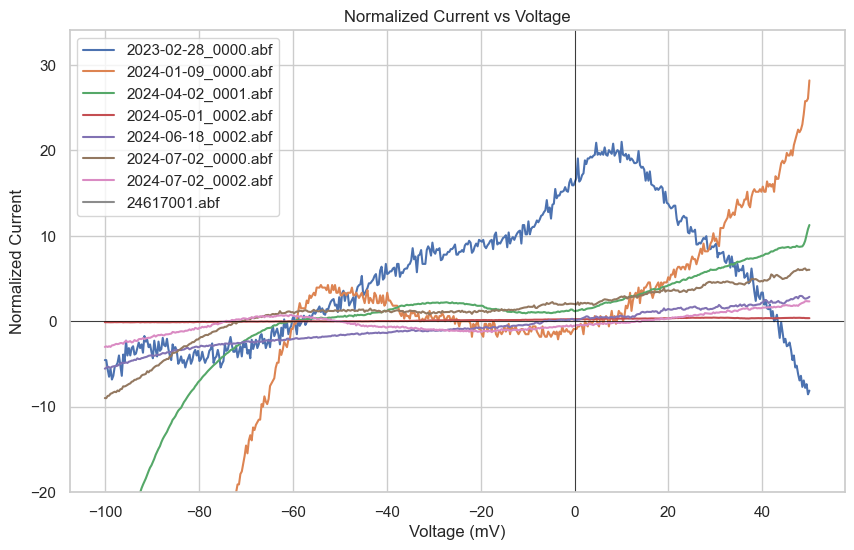

In [192]:
import matplotlib.pyplot as plt

# Припустимо, у вас вже є дані для графіка
# Візьмемо приклад, що result_df має колонки 'Voltage mV' та 'Normalized Current'
plt.figure(figsize=(10, 6))

# Побудова графіку
for file_name in result_df['File'].unique():
    plt.plot(result_df[result_df['File'] == file_name]['Voltage mV'], 
             result_df[result_df['File'] == file_name]['Normalized Current'], 
             label=file_name)

# Встановлення меж осі Y
plt.ylim(bottom=-20)  # Встановлюємо нижній ліміт на 40, верхній залишаємо без змін

# Додавання вертикальної та горизонтальної ліній через (0, 0)
plt.axhline(0, color='black', linewidth=0.5)  # Горизонтальна лінія через 0
plt.axvline(0, color='black', linewidth=0.5)  # Вертикальна лінія через 0

# Додаємо легенду, заголовок та підписи
plt.legend()
plt.title('Normalized Current vs Voltage')
plt.xlabel('Voltage (mV)')
plt.ylabel('Normalized Current')
plt.grid(True)

# Показати графік
plt.show()


Сummary DataFrame:
     Voltage mV Normalized Current_mean  Normalized Current_std  \
0   -100.000000              -20.472064               32.157605   
1    -99.699399              -20.305969               31.928364   
2    -99.398798              -20.080634               31.185413   
3    -99.098196              -19.865639               30.443127   
4    -98.797595              -19.763594               30.812309   
..          ...                     ...                     ...   
495   48.797595                5.394899                9.685923   
496   49.098196                5.557493               10.386514   
497   49.398798                5.694128               10.336356   
498   49.699399                5.678487               10.740240   
499   50.000000                6.128073               11.357951   

     Standard Error  
0         12.154432  
1         12.067787  
2         11.786978  
3         11.506421  
4         11.645958  
..              ...  
495        3.660935  


C:\Users\levkr\AppData\Local\Temp\ipykernel_34932\249132658.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


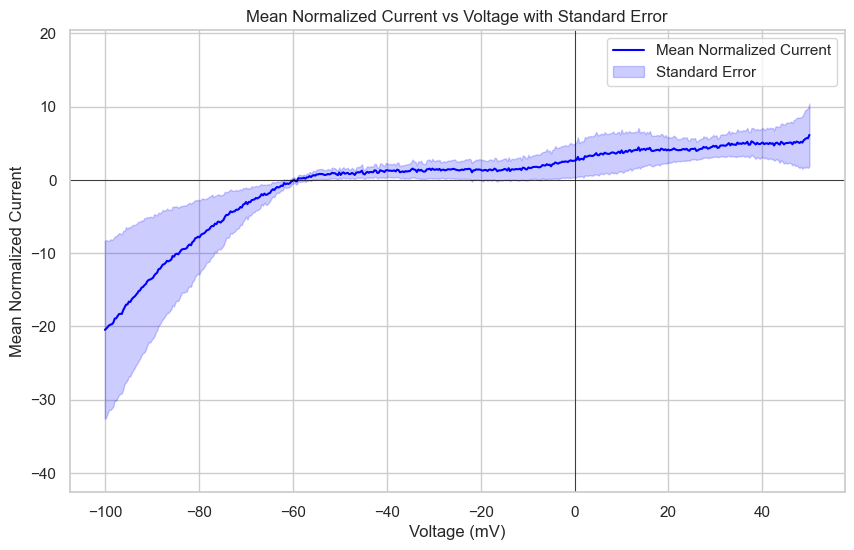

: 

In [207]:
import matplotlib.pyplot as plt
import numpy as np

# Виключаємо записи з '2024-07-02_0003.abf'
filtered_result_df = result_df[result_df['File'] != '2024-07-02_0003.abf']

# Групуємо за 'Voltage mV' та обчислюємо середнє значення
mean_values = filtered_result_df.groupby('Voltage mV')['Normalized Current'].mean().reset_index()

# Обчислюємо стандартну похибку
count_values = filtered_result_df.groupby('Voltage mV')['Normalized Current'].count().reset_index(name='count')
std_values = filtered_result_df.groupby('Voltage mV')['Normalized Current'].std().reset_index()

# Додаємо стандартну похибку до даних
summary_df = mean_values.merge(std_values, on='Voltage mV', suffixes=('_mean', '_std'))
summary_df['Standard Error'] = summary_df['Normalized Current_std'] / np.sqrt(count_values['count'])

# Витягуємо дані для побудови графіку
voltages = summary_df['Voltage mV']
mean_current = summary_df['Normalized Current_mean']
se_current = summary_df['Standard Error']

# Друкуємо вміст summary_df для перевірки
print("Сummary DataFrame:")
print(summary_df)

# Перевірка на наявність NaN
mean_current = mean_current.fillna(0)
se_current = se_current.fillna(0)

# Побудова графіку
plt.figure(figsize=(10, 6))

# Лінія усереднення
plt.plot(voltages, mean_current, label='Mean Normalized Current', color='blue')

# Лінії відхилення (стандартна похибка)
plt.fill_between(voltages, mean_current - se_current, mean_current + se_current, 
                 color='blue', alpha=0.2, label='Standard Error')

# Встановлення меж осі Y
plt.ylim(bottom=min(mean_current - se_current) - 10, top=max(mean_current + se_current) + 10)  # Установлюємо нижній та верхній ліміти

# Додавання вертикальної та горизонтальної ліній через (0, 0)
plt.axhline(0, color='black', linewidth=0.5)  # Горизонтальна лінія через 0
plt.axvline(0, color='black', linewidth=0.5)  # Вертикальна лінія через 0

# Додаємо легенду, заголовок та підписи
plt.legend()
plt.title('Mean Normalized Current vs Voltage with Standard Error')
plt.xlabel('Voltage (mV)')
plt.ylabel('Mean Normalized Current')
plt.grid(True)

# Показати графік
plt.show()


c:\Users\levkr\anaconda3\Lib\site-packages\plotnine\stats\stat_smooth.py:215: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.
c:\Users\levkr\anaconda3\Lib\site-packages\plotnine\stats\stat_smooth.py:215: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.
c:\Users\levkr\anaconda3\Lib\site-packages\plotnine\stats\stat_smooth.py:215: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.
c:\Users\levkr\anaconda3\Lib\site-packages\plotnine\stats\stat_smooth.py:215: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surpri

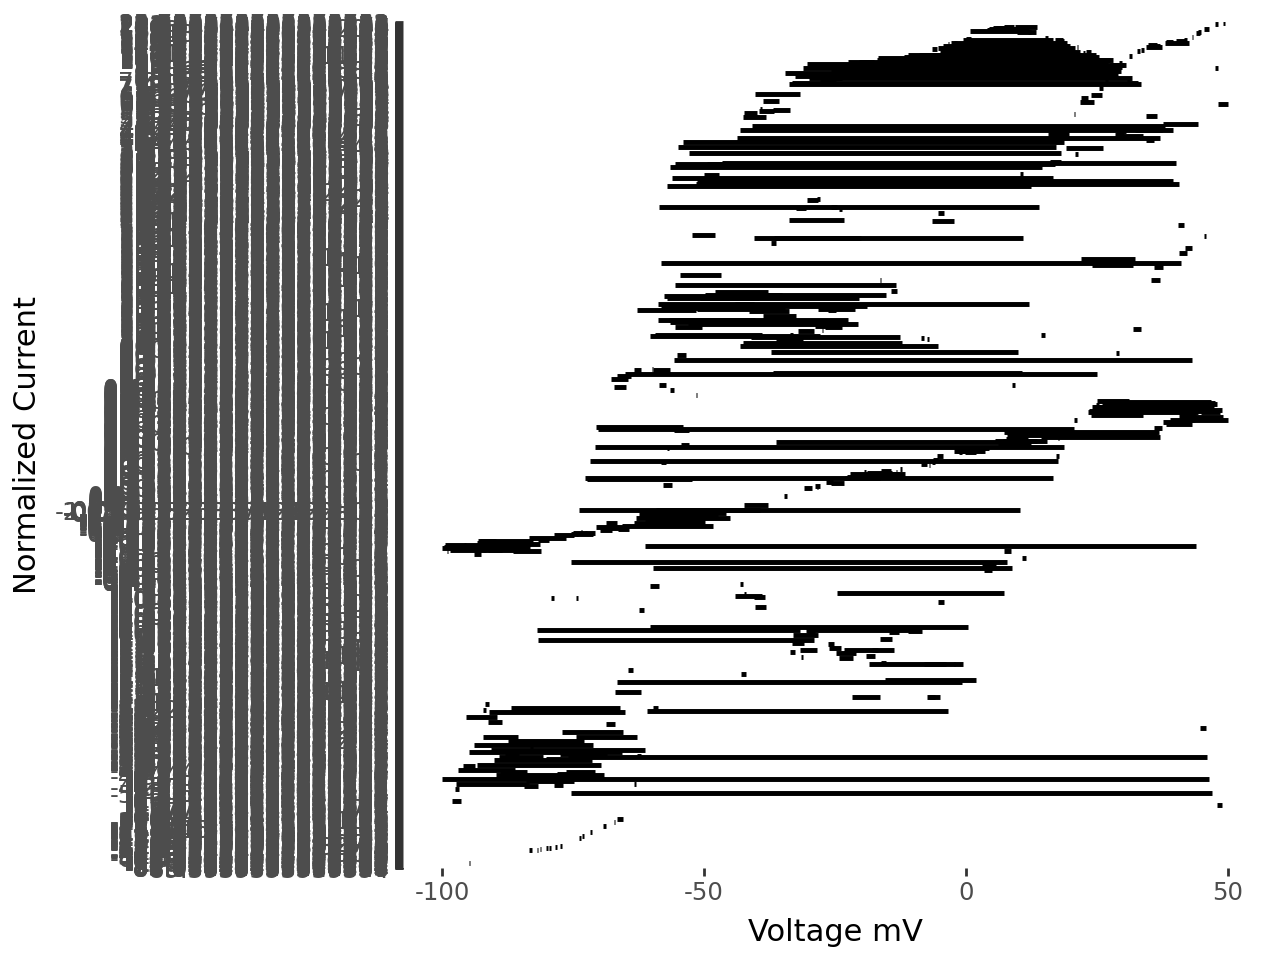

In [202]:
from plotnine import *

(ggplot(result_df, aes(x = 'Voltage mV', y = 'Normalized Current'))+geom_smooth())

In [165]:
import pandas as pd

# Припускаючи, що ваш датафрейм називається grouped
# Знаходимо всі рядки, де Stage == 'Capacitance measurement'
capacitance_measurement = grouped[grouped['Stage'] == 'Capacitance measurement']

# Знаходимо current_max і current_min, а також папку для цих файлів
results = capacitance_measurement.groupby(['Folder', 'File', 'Cell_Number']).agg(
    current_max=('Current', 'max'),
    current_min=('Current', 'min')
).reset_index()

# Зберігаємо лише унікальні значення Cell_Number і Folder для отримання File_current
unique_files = grouped[['Cell_Number', 'Folder', 'File']].drop_duplicates()

# Об'єднуємо результати з унікальними файлами
results = results.merge(
    unique_files,
    on=['Cell_Number', 'Folder'],
    how='left'
)

# Перейменовуємо колонки
results.rename(columns={'File_y': 'File_current', 'File_x': 'File_capacitance'}, inplace=True)

# Додаємо умову, що File_current != File_capacitance
results = results[results['File_current'] != results['File_capacitance']]

# Перевіряємо результат
print(results[['Folder', 'File_capacitance', 'current_max', 'current_min', 'File_current']].drop_duplicates())

# Тепер для кожного файлу File_current, розраховуємо Normalized Current
# Створюємо новий DataFrame cv_data для збереження результатів
cv_data = pd.DataFrame()

# Проходимо по кожному запису results і обчислюємо Normalized Current для відповідного File_current
for index, row in results.iterrows():
    # Отримуємо дані для File_current
    file_current_data = grouped[grouped['File'] == row['File_current']]
    
    # Обчислюємо Normalized Current: Current / (current_max - current_min)
    file_current_data['Normalized Current'] = file_current_data['Current'] / (row['current_max'] - row['current_min'])
    
    # Додаємо Normalized Current у новий датафрейм cv_data, групуючи по 'File' і 'Time (s)'
    grouped_file_data = file_current_data.groupby(['File', 'Time (s)', 'Stage']).agg(
        Normalized_Current=('Normalized Current', 'mean'),
        Voltage_mV=('Voltage mV', 'first'),
        SEM=('SEM', 'first')
    ).reset_index()
    
    # Додаємо похибку (Error)
    grouped_file_data['Error'] = grouped_file_data['SEM'] / (row['current_max'] - row['current_min'])
    
    # Додаємо ці дані до cv_data
    cv_data = pd.concat([cv_data, grouped_file_data])

# Перевіряємо результати
print(cv_data.head())


In [77]:
save_data_with_dask(grouped, 'abf_data_mean_table')

Saved: Sheet1
Data saved to d:\Наука\Проєкти\K-АТФ чутливі канали\Кардіоміоцити\Дорослі\Дані\Adult\Adult_CM_analysis\Jupiter_notebooks\..\outputs\abf_data_mean_table.xlsx


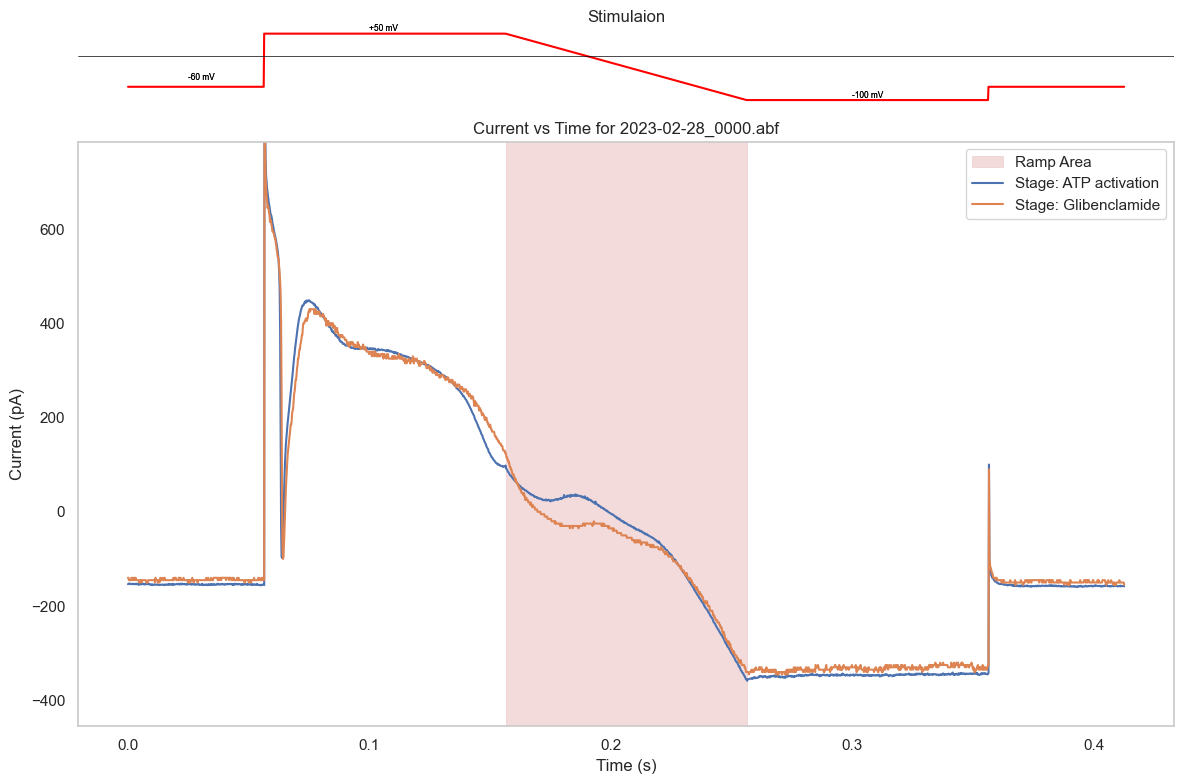

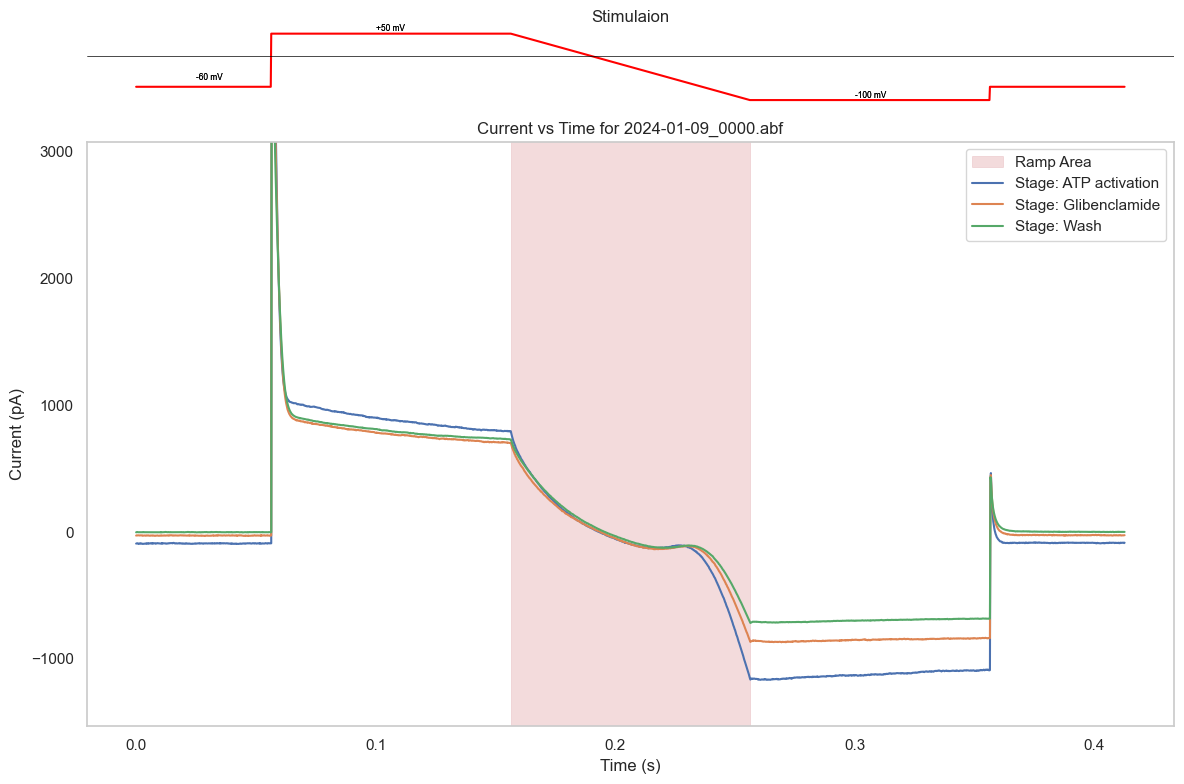

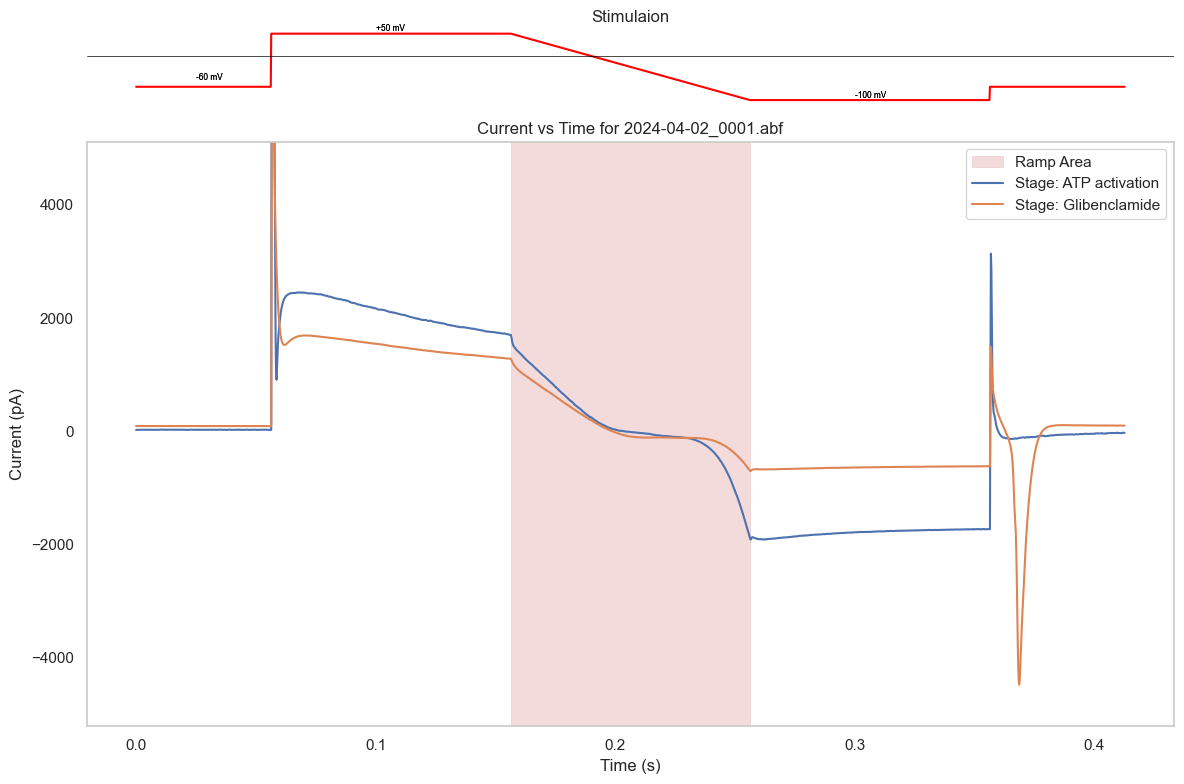

C:\Users\levkr\AppData\Local\Temp\ipykernel_34932\1724912832.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


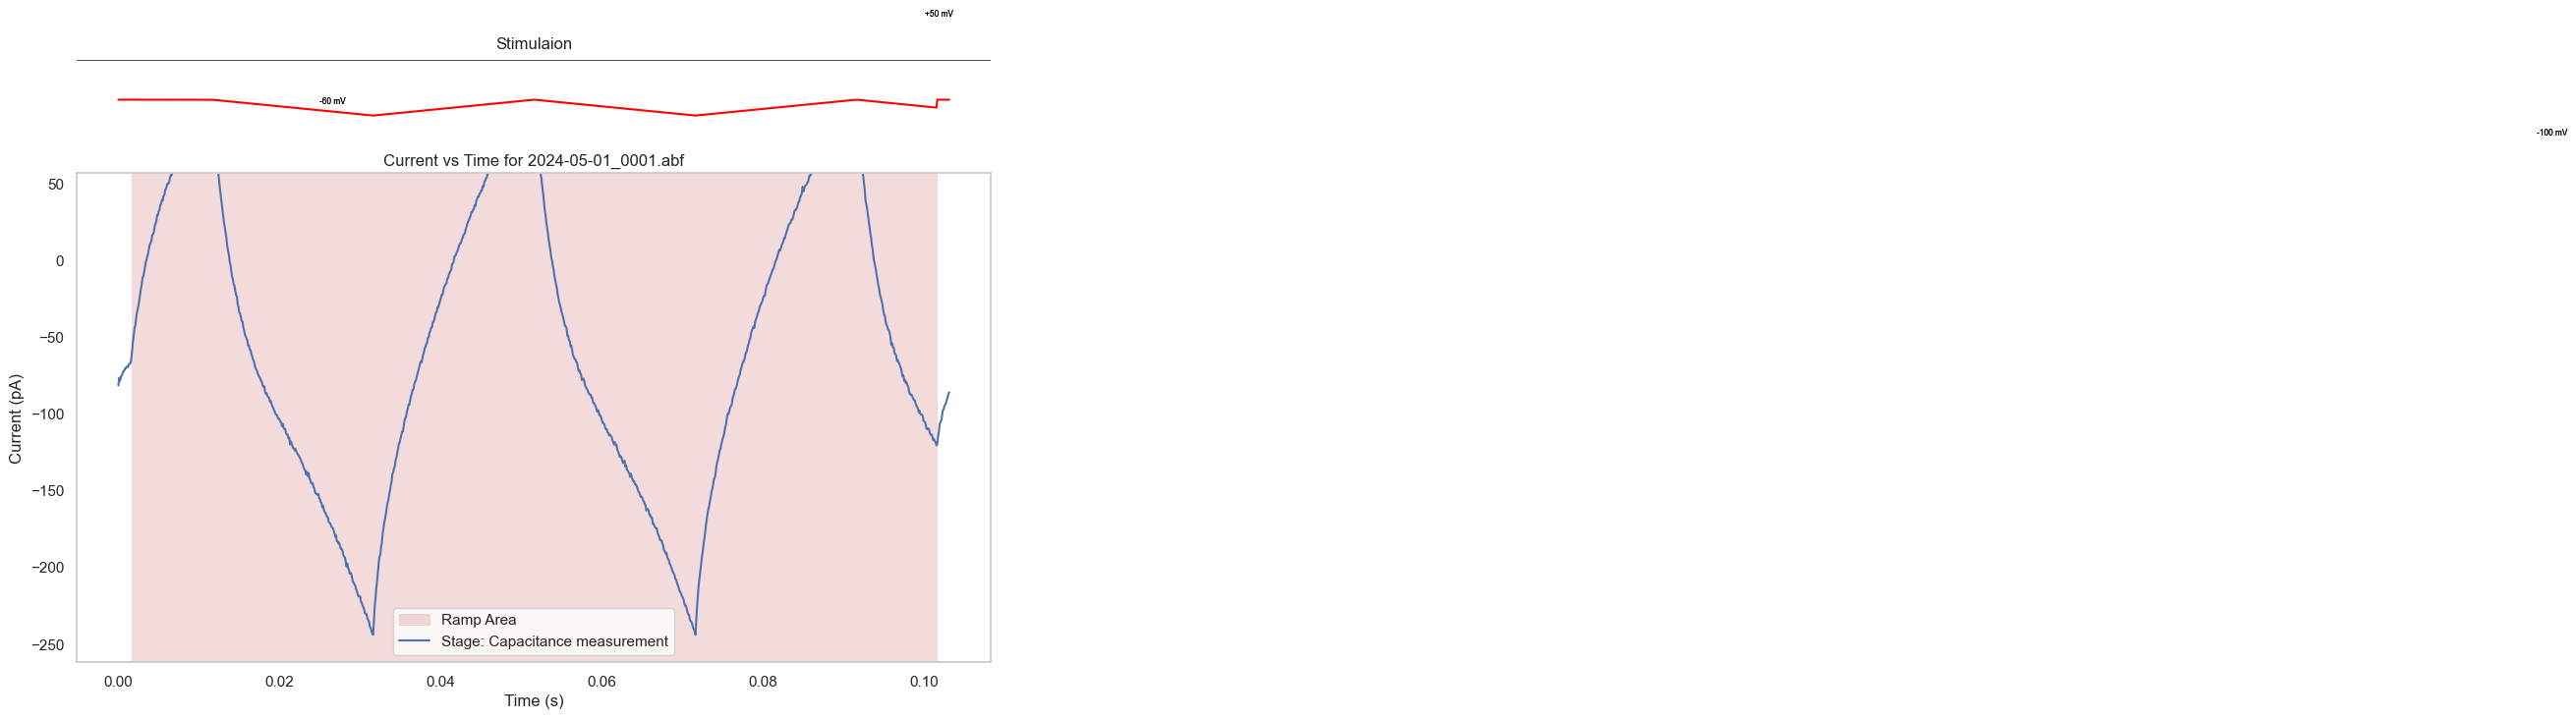

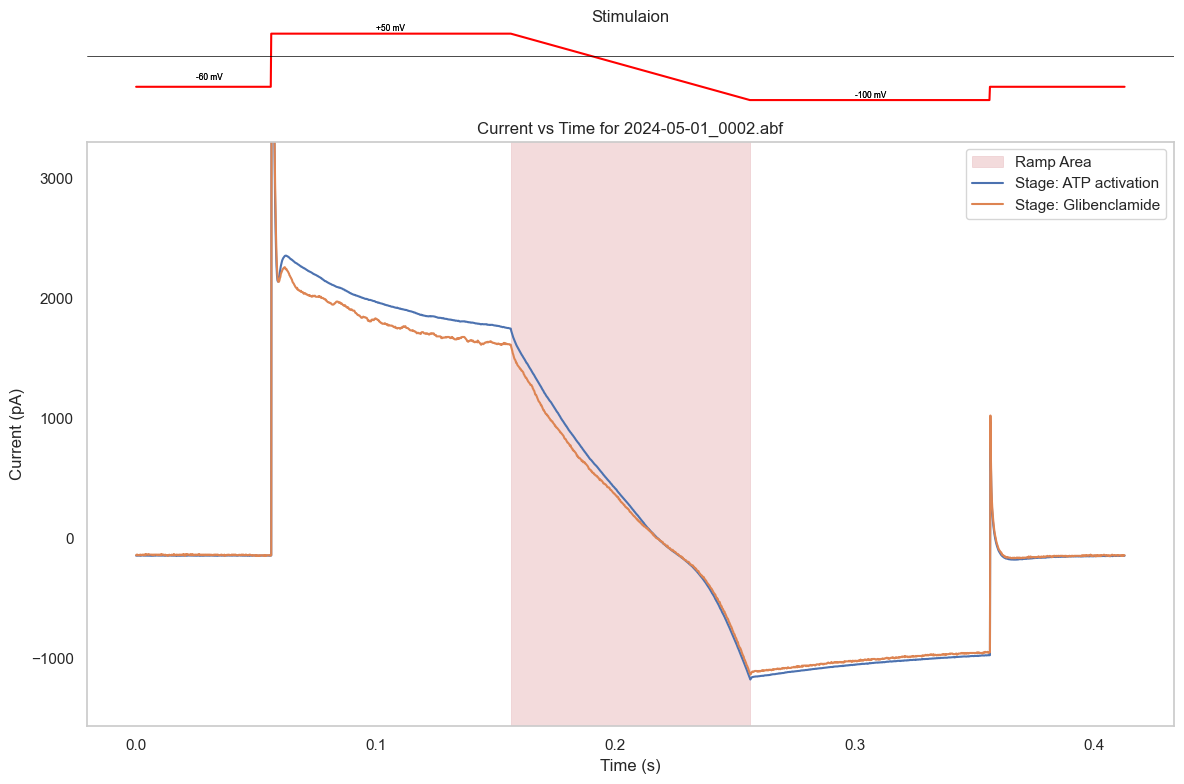

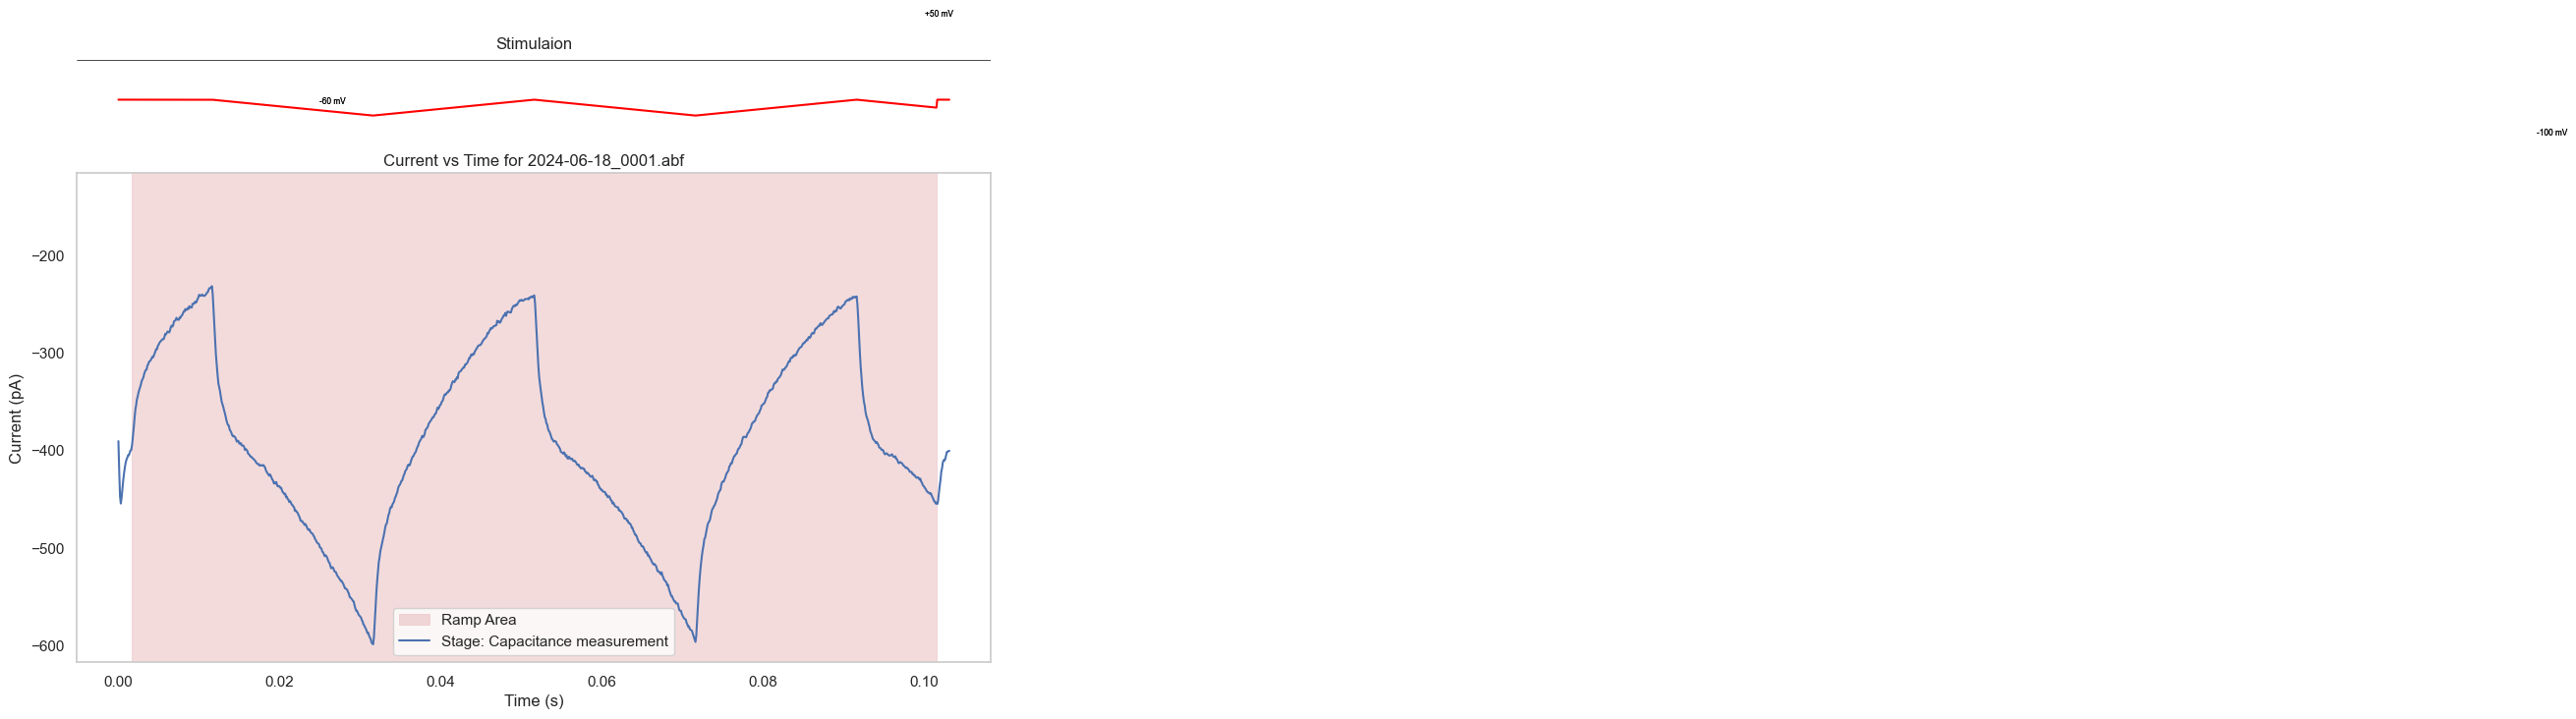

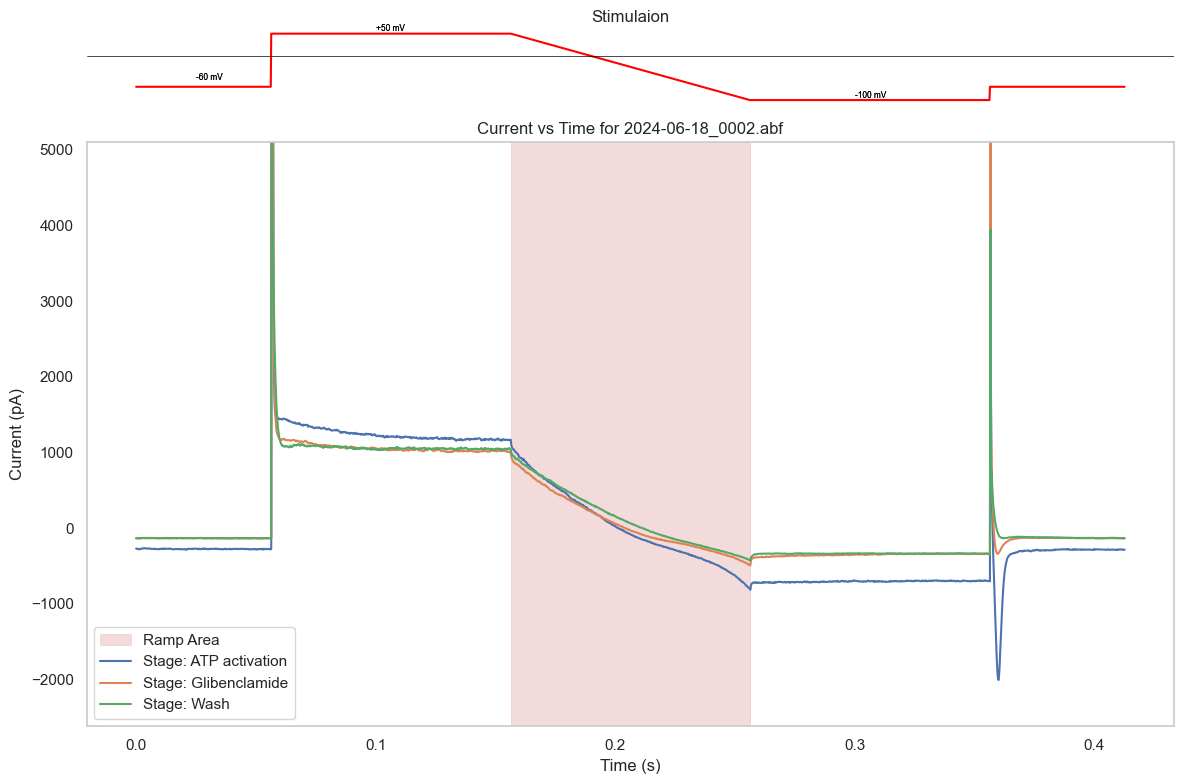

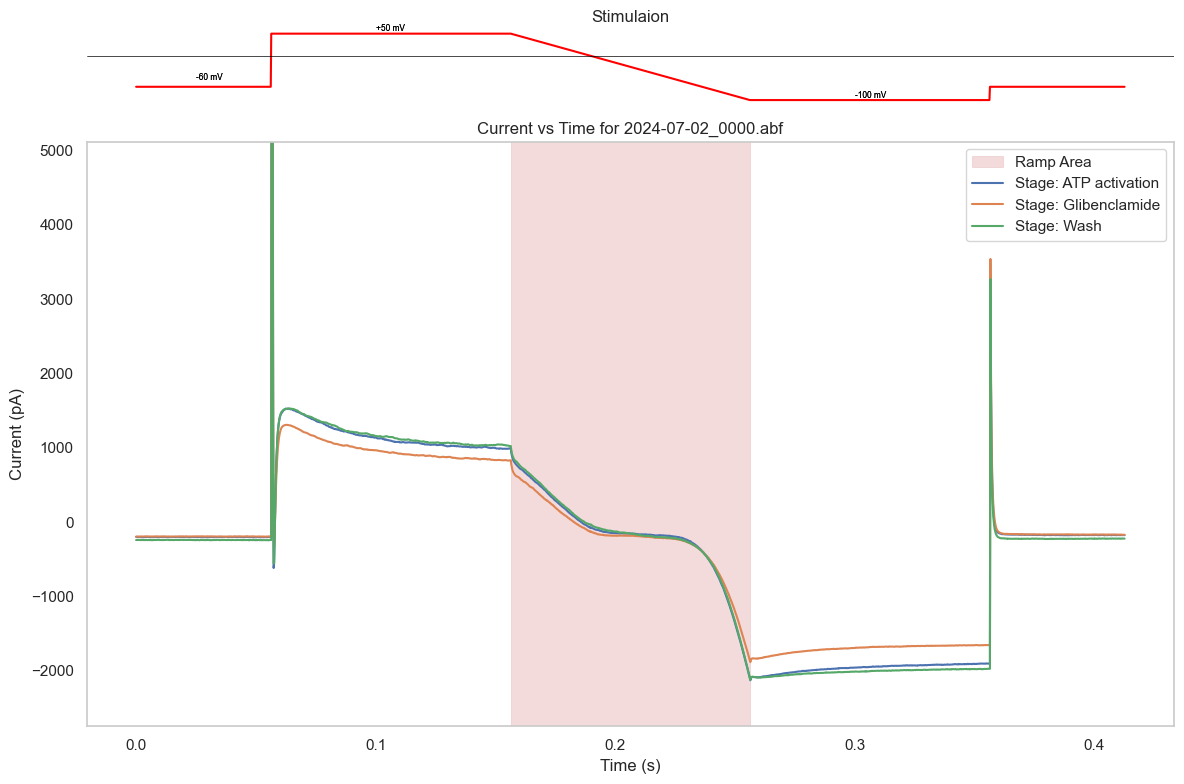

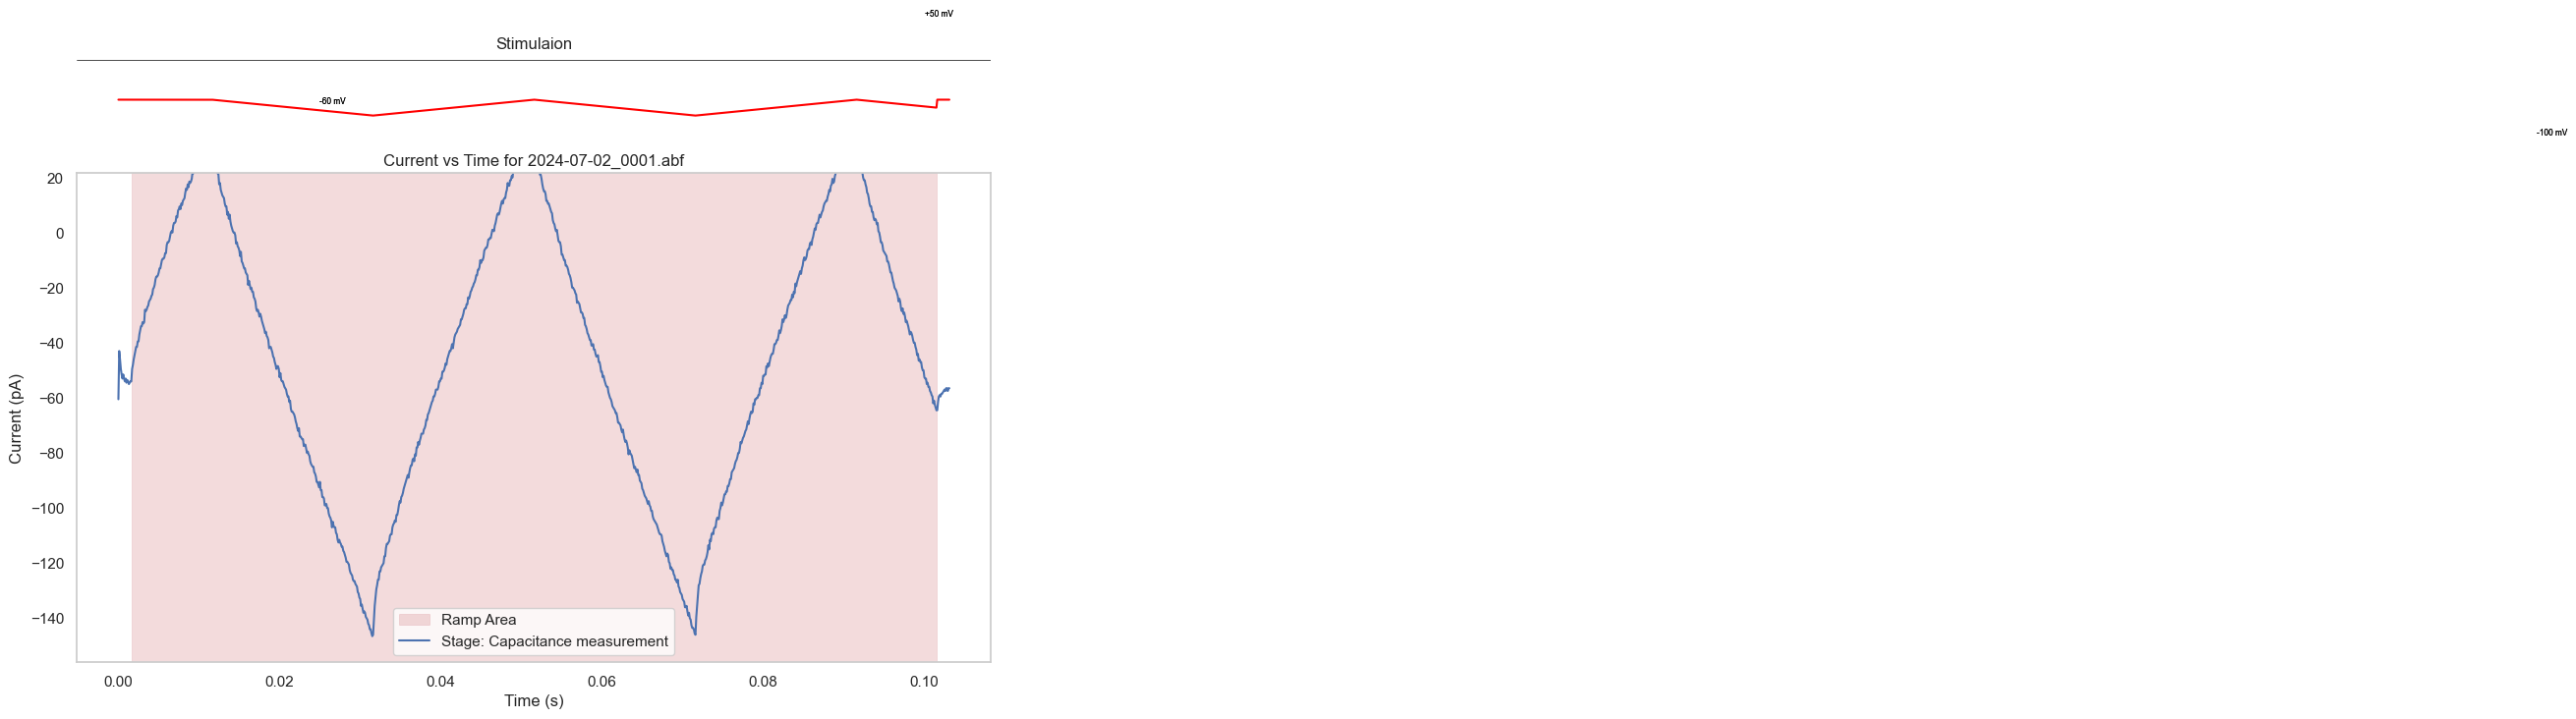

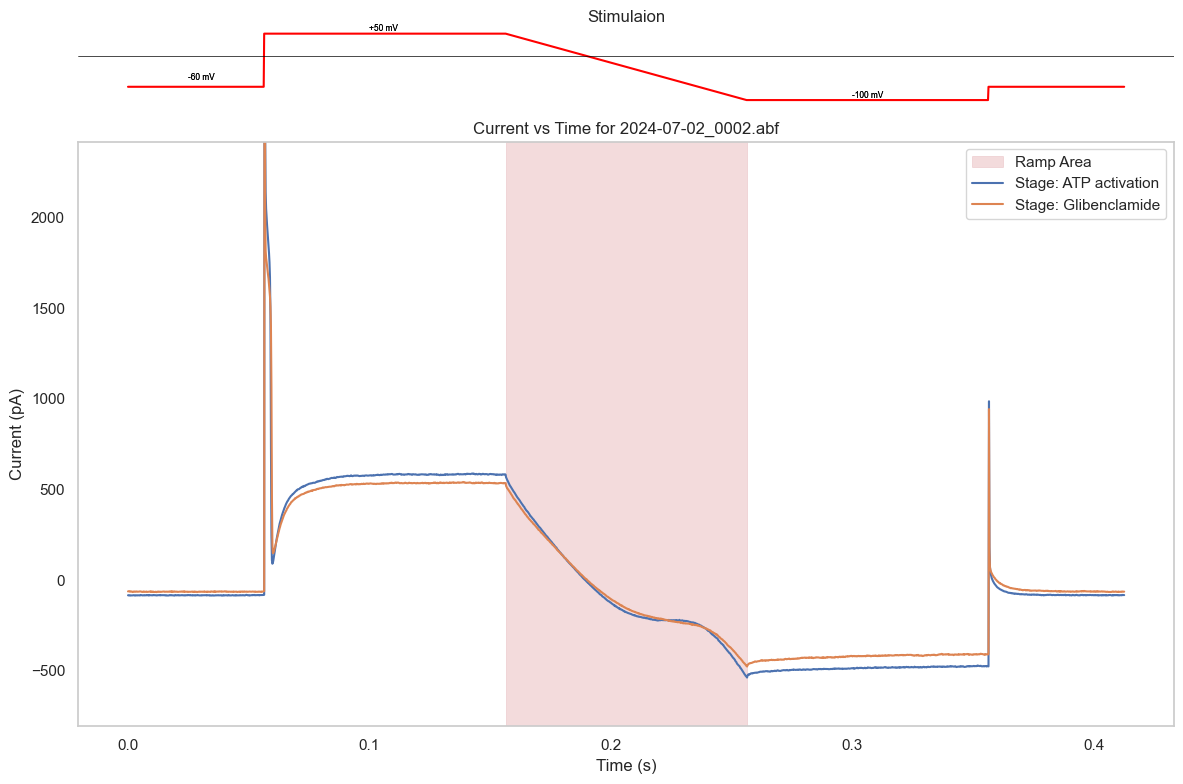

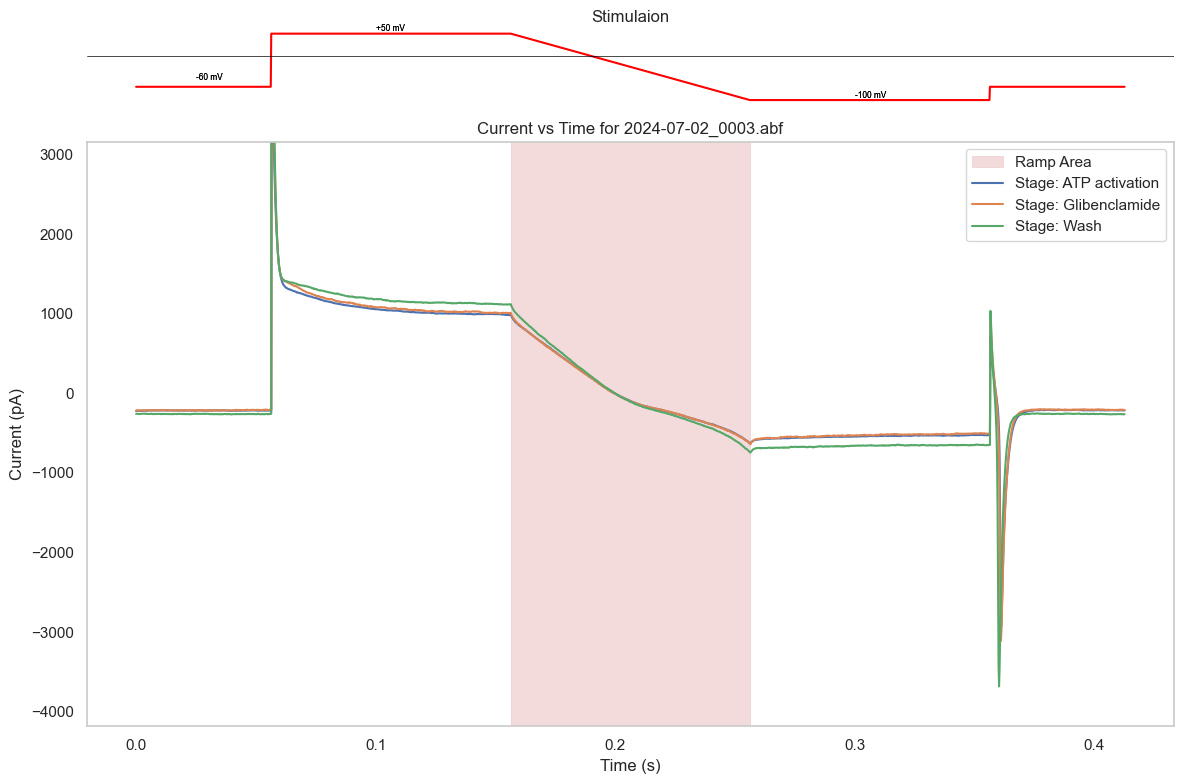

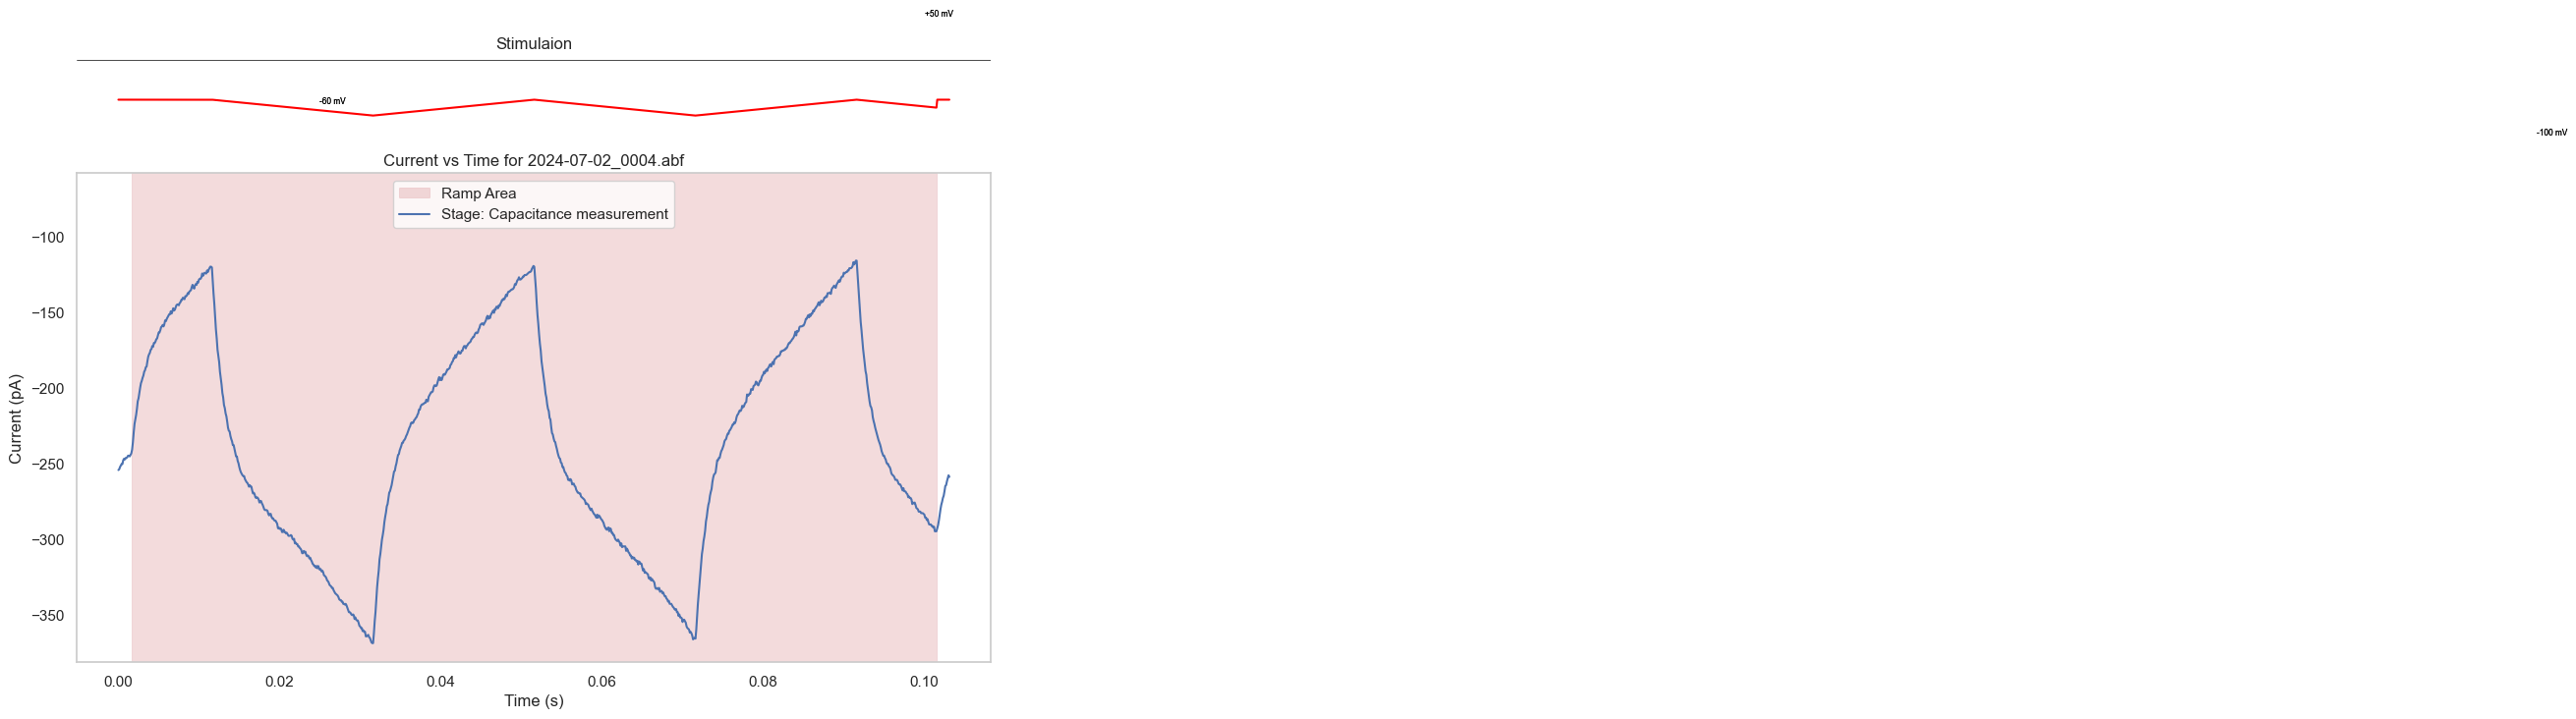

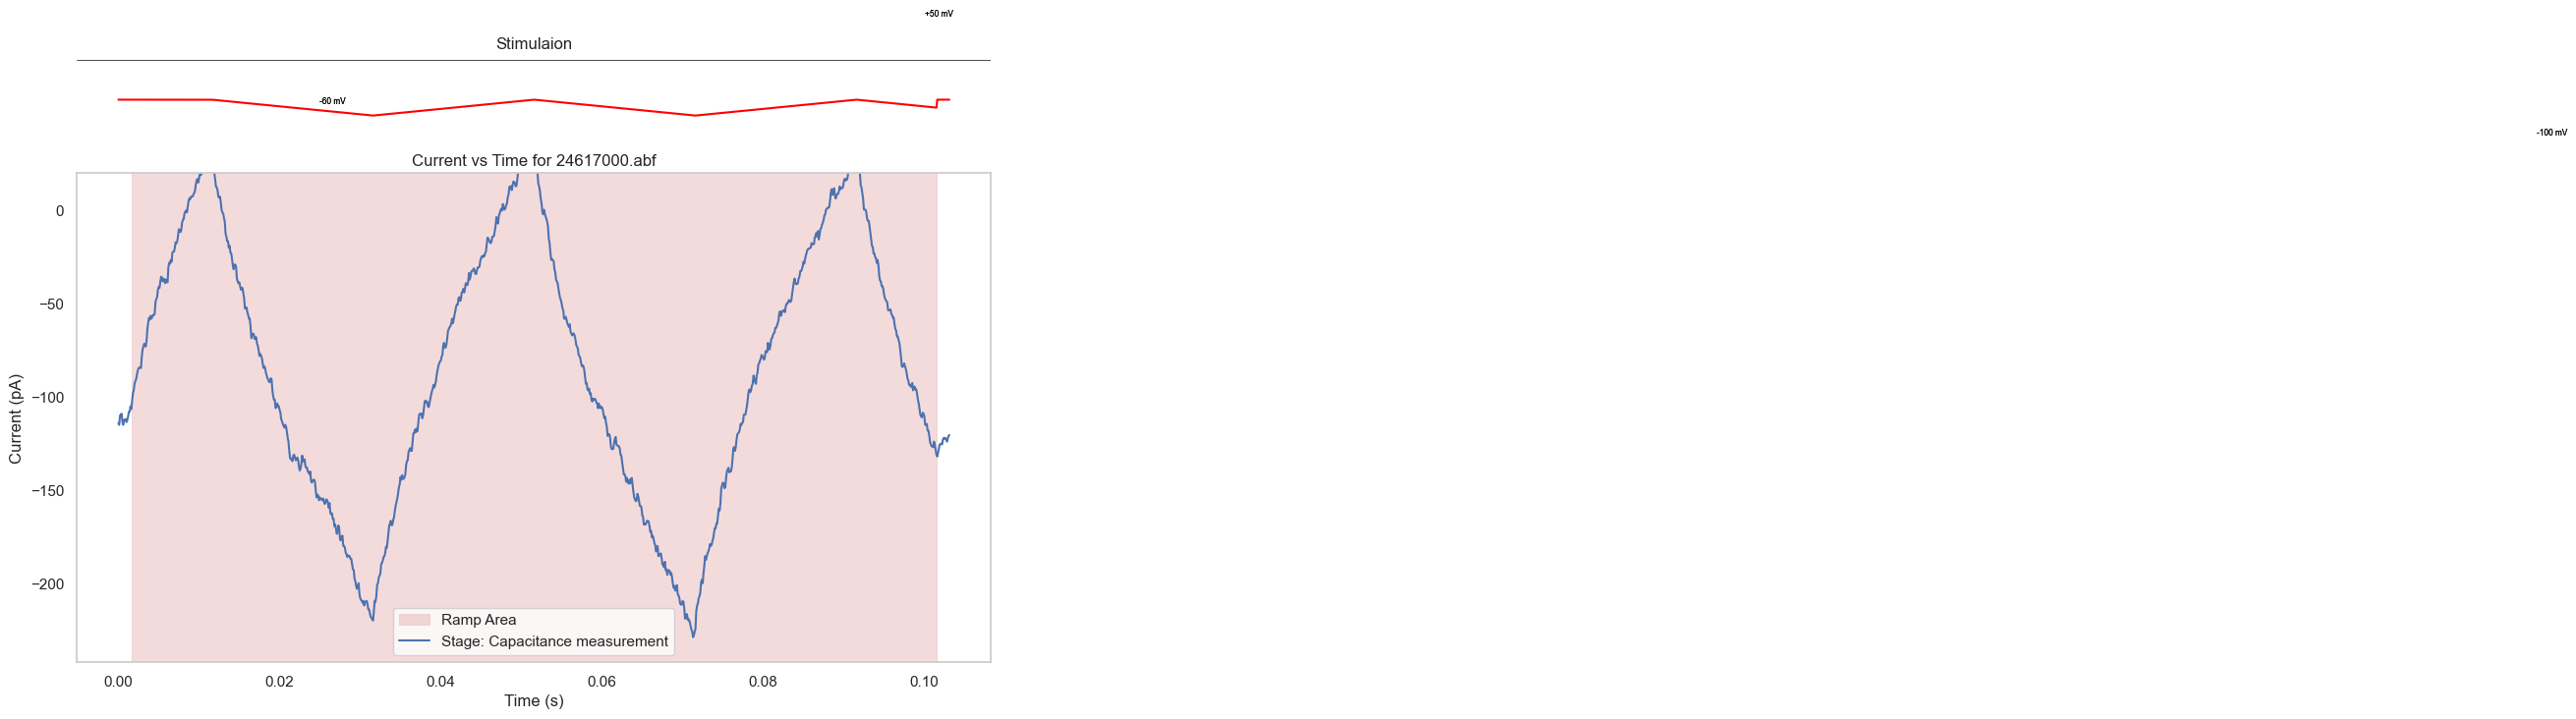

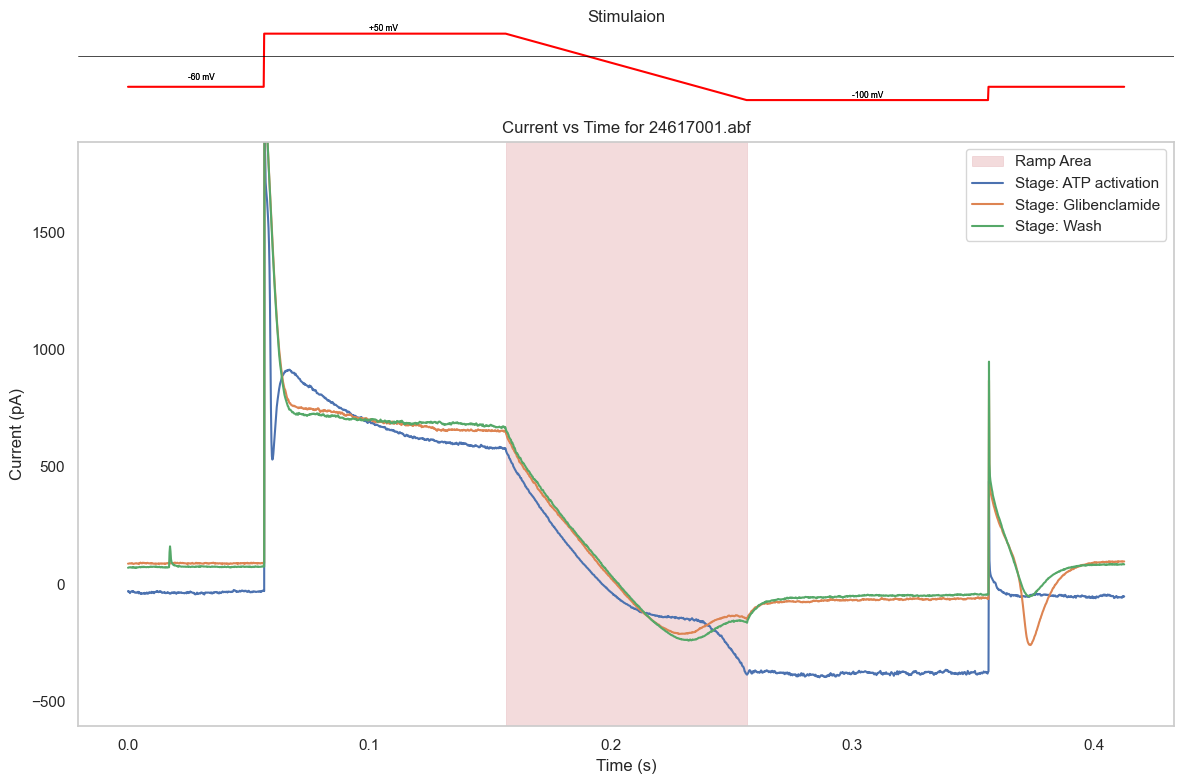

In [157]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Створення графіків для кожного файлу
for file_name in grouped['File'].unique():
    file_data = grouped[grouped['File'] == file_name]

    # Використання GridSpec для управління висотою subplot
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[0.25, 2])  # Висота Voltage в чотири рази менша

    # Графік Voltage vs Time
    ax2 = fig.add_subplot(gs[0])
    ax2.plot(file_data['Time (s)'], file_data['Voltage mV'], color='red', label='Voltage (mV)')  # Змінено колір на червоний
    # Додавання надписів в центрі інтервалів
    ax2.text(0.025, -55, '-60 mV', fontsize=6, color='black')  # Піднято надпис
    ax2.text(0.3, -95, '-100 mV', fontsize=6, color='black')  # Піднято надпис
    ax2.text(0.1, 55, '+50 mV', fontsize=6, color='black')  # Піднято надпис
    ax2.axhline(0, color='black', linewidth=0.5)  # Додаємо горизонтальну лінію на y=0
    # Приховуємо осі
    ax2.get_xaxis().set_visible(False)  # Приховуємо вісь X
    ax2.get_yaxis().set_visible(False)  # Приховуємо вісь Y
    # Приховуємо рамку (сплайни)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.set_title('Stimulaion')
    ax2.grid()

    # Додавання надписів в центрі інтервалів
    ax2.text(0.025, -55, '-60 mV', fontsize=6, color='black')  # Піднято надпис
    ax2.text(0.3, -95, '-100 mV', fontsize=6, color='black')  # Піднято надпис
    ax2.text(0.1, 55, '+50 mV', fontsize=6, color='black')  # Піднято надпис

    # Графік Current vs Time
    ax1 = fig.add_subplot(gs[1])
    
    # Визначаємо область Ramp
    ramp_data = file_data[file_data['Epoch'] == 'Ramp']
    if not ramp_data.empty:
        t1 = ramp_data['Time (s)'].min()  # початок Ramp
        t2 = ramp_data['Time (s)'].max()  # кінець Ramp
        ax1.axvspan(t1, t2, color='r', alpha=0.2, lw=.5, label='Ramp Area')  # Задаємо прозору область
    
    # Відображення даних для кожного етапу
    for stage in file_data['Stage'].unique():
        stage_data = file_data[file_data['Stage'] == stage]
        ax1.plot(stage_data['Time (s)'], stage_data['Current'], label=f'Stage: {stage}')

    # Розрахунок верхнього ліміту по осі Y
    y_max = file_data['Current'].max() / 2
    ax1.set_ylim(top=y_max)  # Встановлюємо тільки верхню межу

    ax1.set_title(f'Current vs Time for {file_name}')
    ax1.set_ylabel('Current (pA)')
    ax1.legend()
    ax1.grid()

    # Спільні підписи осей
    ax1.set_xlabel('Time (s)')

    plt.tight_layout()  # Автоматичне налаштування для уникнення перекриттів
    plt.show()


Тестовий вивід графіків